In [273]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

In [274]:
def gen_sample(batch_size, N_agents, in_dim = None, L = None):
    """ 
        generates an inital states in [0,L1] x [0,L2] x ... x [0, Ln] of shape [Batch_size, in_dim]
    """
    if in_dim is None and L is None:
        raise ValueError("Need either L or in dim to be set")
    if in_dim is None:
        in_dim = len(L)
    if L is None:
        L = [1. for _ in range(in_dim)]
    x = torch.rand(batch_size, N_agents, in_dim).abs()
    for i in range(len(L)):
        x[:, :, i] = torch.clamp(x[:, :, i], max=L[i])
    return x


In [275]:
N_Agents = 2
in_dim = 1
batch_size = 128
num_samples = 1000 ## samples linspace of target and objective funciton
n_samples = 2048 ## samples per epoch TODO better naming
timesteps = 30
lam = 0.5
control_energy_reg = 1e-6 ### regularization on maximum control energy
u_max = 100 # does not do anything currently
thres = -1e-2 ### softness on constraint (will penalize when this much outside of rect)


In [276]:
densties = ['custom']
regions = [
        torch.tensor([[.0, .3]]),
        torch.tensor([[.6, .9]])
        ]
weights = [.5, .5]

In [277]:
def custom_pdf(x):
    """
     Define a custom probability density function (PDF).
    """
    #x = x.item()
    return torch.tensor(np.where(((x > 0) & (x < 1)), 1., 0), dtype = torch.float32)
    #return torch.tensor(np.where(((x > 0) & (x < 0.3)) | ((x > 0.6) & (x < 0.9)), 5 / 3, 0))

In [278]:
import Ergodic_Loss_timedomain
import Recursive_KAN
import sys
sys.path.append(r'\\hhi.de\benutzer\home\prass\Master\Code_RNN_KAN\Recursive_kan\Ergodic_Loss_timedomain.py') 
sys.path.append(r'\\hhi.de\benutzer\home\prass\Master\Code_RNN_KAN\Recursive_kan\Recursive_KAN.py') 
import importlib
importlib.reload(Ergodic_Loss_timedomain)
importlib.reload(Recursive_KAN)
criterion = Ergodic_Loss_timedomain.Ergodicity_Loss(N_Agents = N_Agents, n_timesteps = timesteps,L = None, in_dim = in_dim, control_energy_reg = control_energy_reg, density = 'custom',verbose = False, pdf = custom_pdf, num_samples = num_samples)
model = Recursive_KAN.KAN_RNN_Layer(N_Agents = N_Agents, in_dim = in_dim, hidden = 128, depth = 2, n_timesteps = timesteps,sys_param_lam= lam, u_max = u_max, network_type='multi', thres = thres)
model.init_hidden(batch_size = batch_size)

In [279]:
exploding_threshold = 1e5  # Example threshold for exploding gradients
vanishing_threshold = 1e-5  # Example threshold for vanishing gradients
def print_grad(model):
    for name, param in model.named_parameters():
        if param.grad is not None:
            grad_norm = param.grad.norm().item()  # Gradient norm (magnitude)
            if grad_norm > exploding_threshold:
                print(f"  *** Exploding gradient detected for {name} ***")
            elif grad_norm < vanishing_threshold:
                print(f"  *** Vanishing gradient detected for {name} ***")


per iter: 1.0450694561004639 total time: 250.81666946411133
Epoch [1/15], Loss: 31.013841
Epoch [2/15], Loss: 15.366493
Epoch [3/15], Loss: 12.645224
Epoch [4/15], Loss: 10.993391
Epoch [5/15], Loss: 9.204567
Epoch [6/15], Loss: 7.957665
Epoch [7/15], Loss: 6.814182
Epoch [8/15], Loss: 6.241347
Epoch [9/15], Loss: 6.313581
Epoch [10/15], Loss: 6.140717
Epoch [11/15], Loss: 5.266242
Epoch [12/15], Loss: 5.110625
Epoch [13/15], Loss: 4.388530
Epoch [14/15], Loss: 5.130484


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch [15/15], Loss: 4.553522


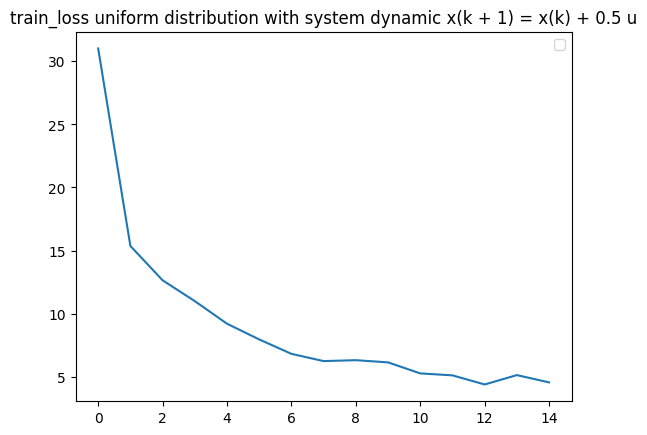

Training Complete!


In [280]:
import time
criterion.verbose = False
epochs = 15  # Number of epochs to train
optimizer = optim.AdamW(model.parameters(), lr=0.001)
train_loss = []
test_loss = []
model.train()  # Set the model to training mode
show = True
for epoch in range(epochs):
    running_loss = 0.0 
    for samples in range(n_samples // batch_size):
        start_time = time.time()
        model.init_hidden(batch_size = batch_size)
        optimizer.zero_grad()
        control , outputs = model(gen_sample(batch_size = batch_size, N_agents = N_Agents, in_dim = in_dim))
        loss = criterion(x = outputs, u = control) + model.penalty #* 1e-2 ## punishment on leaving the rect
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        #print_grad(model)
        if show:
            show = False
            print("per iter:", time.time()- start_time,"total time:" , (time.time()- start_time) * (n_samples / batch_size) * epochs)
    avg_loss = running_loss / (n_samples // batch_size)
    train_loss.append(avg_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}")
plt.plot(train_loss)
plt.title(f'train_loss uniform distribution with system dynamic x(k + 1) = x(k) + {lam} u')
plt.legend()
plt.show()
print("Training Complete!")

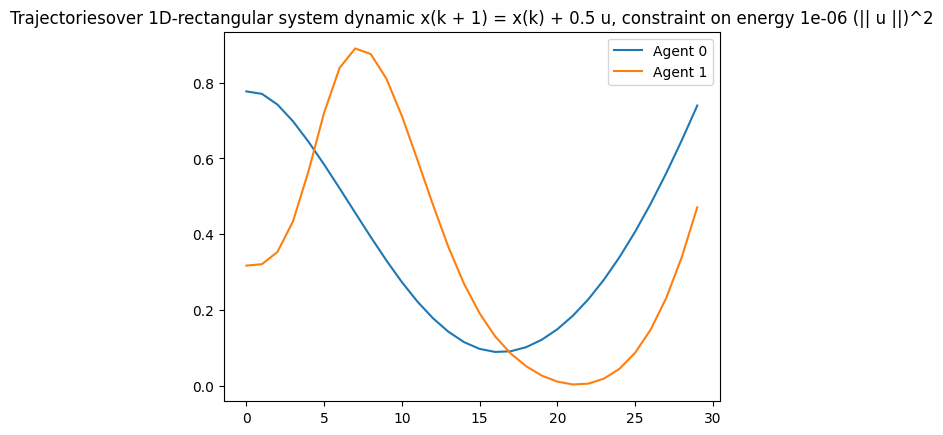

In [285]:
#plot trajectory
model.eval()
inital_state = gen_sample(batch_size = 1, N_agents = N_Agents, in_dim = in_dim)
model.init_hidden(batch_size = 1)
outs, control = model(inital_state)
for j in range(N_Agents):
    plt.plot(outs[:,:,j,:].squeeze().detach(), label = f'Agent {j}')
plt.title(f'Trajectoriesover 1D-rectangular system dynamic x(k + 1) = x(k) + {lam} u, constraint on energy {control_energy_reg} (|| u ||)^2')
plt.legend()
plt.show()



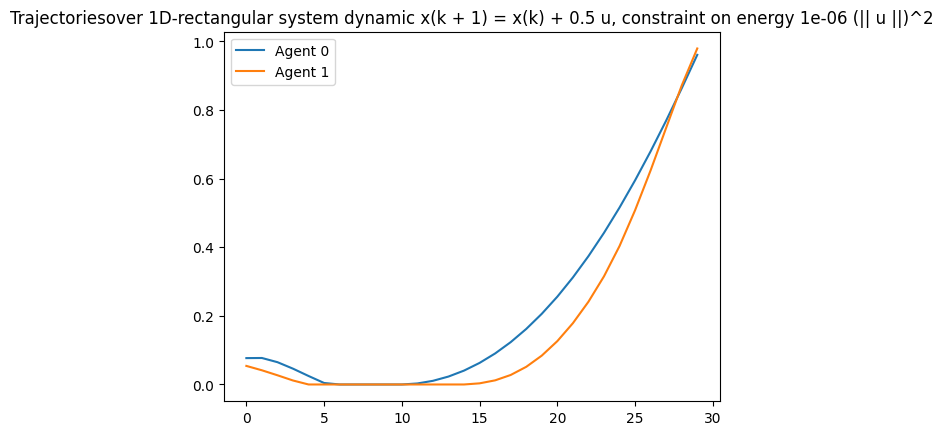

model tensor([6.5538e+00, 7.0083e+00, 7.4001e+00, 7.7190e+00, 7.9597e+00, 8.1218e+00,
        8.2094e+00, 8.2297e+00, 8.1924e+00, 8.1082e+00, 7.9879e+00, 7.8415e+00,
        7.6783e+00, 7.5058e+00, 7.3305e+00, 7.1571e+00, 6.9889e+00, 6.8284e+00,
        6.6767e+00, 6.5343e+00, 6.4011e+00, 6.2769e+00, 6.1609e+00, 6.0527e+00,
        5.9518e+00, 5.8576e+00, 5.7700e+00, 5.6886e+00, 5.6133e+00, 5.5438e+00,
        5.4801e+00, 5.4217e+00, 5.3683e+00, 5.3194e+00, 5.2746e+00, 5.2332e+00,
        5.1945e+00, 5.1579e+00, 5.1226e+00, 5.0878e+00, 5.0526e+00, 5.0163e+00,
        4.9779e+00, 4.9366e+00, 4.8913e+00, 4.8411e+00, 4.7854e+00, 4.7235e+00,
        4.6550e+00, 4.5799e+00, 4.4988e+00, 4.4125e+00, 4.3226e+00, 4.2307e+00,
        4.1391e+00, 4.0502e+00, 3.9664e+00, 3.8897e+00, 3.8224e+00, 3.7657e+00,
        3.7209e+00, 3.6886e+00, 3.6690e+00, 3.6617e+00, 3.6660e+00, 3.6809e+00,
        3.7048e+00, 3.7359e+00, 3.7716e+00, 3.8092e+00, 3.8452e+00, 3.8756e+00,
        3.8960e+00, 3.9017e+00, 3.

tensor(4.3712, grad_fn=<AddBackward0>)

In [304]:
import Ergodic_Loss_timedomain
import sys
sys.path.append(r'\\hhi.de\benutzer\home\prass\Master\Code_RNN_KAN\Recursive_kan\Ergodic_Loss_timedomain.py') 
import importlib
importlib.reload(Ergodic_Loss_timedomain)
criterion = Ergodic_Loss_timedomain.Ergodicity_Loss(N_Agents = N_Agents, n_timesteps = timesteps,L = None, in_dim = in_dim,control_energy_reg = control_energy_reg, density = 'custom', pdf = custom_pdf, max_pdf = 1, num_samples = 1000)
inital_state = gen_sample(batch_size = 1, N_agents = N_Agents, in_dim = in_dim)
model.init_hidden(batch_size = 1)
outs, control = model(inital_state)
for j in range(N_Agents):
    plt.plot(outs[:,:,j,:].squeeze().detach(), label = f'Agent {j}')
plt.title(f'Trajectoriesover 1D-rectangular system dynamic x(k + 1) = x(k) + {lam} u, constraint on energy {control_energy_reg} (|| u ||)^2')
plt.legend()
plt.show()
criterion.verbose = True
criterion(x = outs, u = control)

In [283]:
indices = torch.nonzero(criterion.function_values[0] > 0)
print(indices)
criterion.samples[indices]

tensor([[  0],
        [  1],
        [  2],
        [  3],
        [  4],
        [  5],
        [  6],
        [  7],
        [  8],
        [  9],
        [ 10],
        [ 11],
        [ 12],
        [ 13],
        [ 14],
        [ 15],
        [ 16],
        [ 17],
        [ 18],
        [ 19],
        [ 20],
        [ 21],
        [ 22],
        [ 23],
        [ 24],
        [ 25],
        [ 26],
        [ 27],
        [ 28],
        [ 29],
        [ 30],
        [ 31],
        [ 32],
        [ 33],
        [ 34],
        [ 35],
        [ 36],
        [ 37],
        [ 38],
        [ 39],
        [ 40],
        [ 41],
        [ 42],
        [ 43],
        [ 44],
        [ 45],
        [ 46],
        [ 47],
        [ 48],
        [ 49],
        [ 50],
        [ 51],
        [ 52],
        [ 53],
        [ 54],
        [ 55],
        [ 56],
        [ 57],
        [ 58],
        [ 59],
        [ 60],
        [ 61],
        [ 62],
        [ 63],
        [ 64],
        [ 65],
        [ 

tensor([[1.0000e-05],
        [1.0110e-03],
        [2.0120e-03],
        [3.0129e-03],
        [4.0139e-03],
        [5.0149e-03],
        [6.0159e-03],
        [7.0169e-03],
        [8.0178e-03],
        [9.0188e-03],
        [1.0020e-02],
        [1.1021e-02],
        [1.2022e-02],
        [1.3023e-02],
        [1.4024e-02],
        [1.5025e-02],
        [1.6026e-02],
        [1.7027e-02],
        [1.8028e-02],
        [1.9029e-02],
        [2.0030e-02],
        [2.1031e-02],
        [2.2032e-02],
        [2.3033e-02],
        [2.4034e-02],
        [2.5035e-02],
        [2.6036e-02],
        [2.7036e-02],
        [2.8037e-02],
        [2.9038e-02],
        [3.0039e-02],
        [3.1040e-02],
        [3.2041e-02],
        [3.3042e-02],
        [3.4043e-02],
        [3.5044e-02],
        [3.6045e-02],
        [3.7046e-02],
        [3.8047e-02],
        [3.9048e-02],
        [4.0049e-02],
        [4.1050e-02],
        [4.2051e-02],
        [4.3052e-02],
        [4.4053e-02],
        [4

In [284]:
criterion(x = outs, u = control)

model tensor([4.1302e+00, 4.4956e+00, 4.8462e+00, 5.1753e+00, 5.4769e+00, 5.7455e+00,
        5.9765e+00, 6.1658e+00, 6.3106e+00, 6.4095e+00, 6.4627e+00, 6.4720e+00,
        6.4410e+00, 6.3744e+00, 6.2779e+00, 6.1575e+00, 6.0192e+00, 5.8688e+00,
        5.7114e+00, 5.5514e+00, 5.3927e+00, 5.2380e+00, 5.0894e+00, 4.9484e+00,
        4.8154e+00, 4.6908e+00, 4.5743e+00, 4.4654e+00, 4.3637e+00, 4.2686e+00,
        4.1795e+00, 4.0960e+00, 4.0178e+00, 3.9445e+00, 3.8758e+00, 3.8115e+00,
        3.7513e+00, 3.6948e+00, 3.6419e+00, 3.5922e+00, 3.5454e+00, 3.5014e+00,
        3.4600e+00, 3.4212e+00, 3.3848e+00, 3.3512e+00, 3.3203e+00, 3.2924e+00,
        3.2679e+00, 3.2471e+00, 3.2306e+00, 3.2188e+00, 3.2124e+00, 3.2121e+00,
        3.2188e+00, 3.2334e+00, 3.2570e+00, 3.2906e+00, 3.3356e+00, 3.3935e+00,
        3.4657e+00, 3.5537e+00, 3.6590e+00, 3.7829e+00, 3.9263e+00, 4.0894e+00,
        4.2718e+00, 4.4718e+00, 4.6864e+00, 4.9114e+00, 5.1413e+00, 5.3696e+00,
        5.5892e+00, 5.7934e+00, 5.

tensor(3.7364, grad_fn=<AddBackward0>)